# DENDRO ID
** Author: ** Gaspard Clerc \
** Date: ** 06/07/2025 \
**  Course:** CAS Machine Learning Transfer Arbeit





## Objective
Train a CNN which is able to distinguish > 95% of the cards. Then build a retrieval system which allow to correctly identify a the class of a card from one specific image

### Structure of File
- Part 1: Module Import
- Part 2: Data Preparation and Visualisation
- Part 3: Model Building
- Part 4: Training
- Part 5: Testing
- Part 6: Results and Discussion
- Part 7: Conclusion and Outlook



## Part 1: Module Import

In [3]:
# Part 1: module Import

# Built-in modules
import os
import random
from pathlib import Path
from glob import glob

# Core scientific stack
import numpy as np
import matplotlib.pyplot as plt

# Machine learning and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import NearestNeighbors

# TensorFlow / Keras
import tensorflow as tf
os.environ["PYTHONHASHSEED"] = "0" # these import help getting always the same results, so that the model can be compared.
os.environ["TF_DETERMINISTIC_OPS"] = "1"   # route TF to deterministic GPU kernels 
# Optional (helps GEMMs on some stacks):
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import tensorflow as tf
random.seed(0); np.random.seed(0); tf.random.set_seed(0)
from tensorflow import keras
from keras import ops
from tensorflow.keras import (
    layers,
    initializers,
    callbacks,
    optimizers,
    metrics,
    mixed_precision,
)
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Set global precision policy
mixed_precision.set_global_policy('mixed_float16')


2025-09-01 22:50:07.564777: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-01 22:50:08.027722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756759808.190229     816 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756759808.235807     816 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-01 22:50:08.662258: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Part 2: Data Preparation and Visualisation
In this section, the images will be imported and separated into Training, Validation and Testing.
Then the images will be paired into positive (same class) and negative (different class), note that a class is here a card.
To increase the calculation speed, the training has been implemented on a GPU. The calculations were made on a linux WSL machine running on windows. 

The following image show how the data are distributed between the different set:

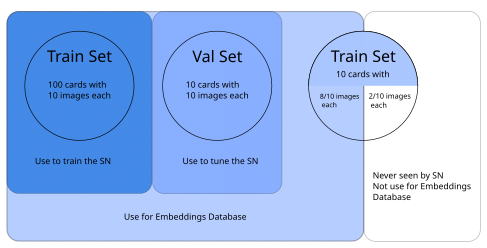

In [4]:
# Path to data
PROJECT_ROOT = Path("/home/gaspard/projects/my-ml-app")
base_path = PROJECT_ROOT / "data" / "TRAIN"

random.seed(42) # set the seed to get consistent result

# obtain all the paths in one class
class_folders = [os.path.join(base_path, d)
                 for d in os.listdir(base_path)
                 if os.path.isdir(os.path.join(base_path, d))]
class_to_images = {cls: glob(os.path.join(cls, '*.jpg')) for cls in class_folders}



def split_by_whole_classes(class_to_images, val_n_classes=10, test_n_classes=10):
    """
    Split classes into train/val/test by class, not by images within each class.
    
    Params:
      class_to_images: dict[class_label] → list[image_paths]
      val_n_classes:   how many classes to hold out for validation
      test_n_classes:  how many classes to hold out for testing
    
    Returns:
      train_imgs, val_imgs, test_imgs: three dicts mapping class → list[images]
    """
    # shuffle class labels
    classes = list(class_to_images.keys())
    random.shuffle(classes)
    
    # pick val/test classes
    val_classes  = set(classes[:val_n_classes])
    test_classes = set(classes[val_n_classes : val_n_classes + test_n_classes])
    
    # assign images
    train_imgs, val_imgs, test_imgs = {}, {}, {}
    for cls, imgs in class_to_images.items():
        if cls in val_classes:
            val_imgs[cls] = imgs.copy()
        elif cls in test_classes:
            test_imgs[cls] = imgs.copy()
        else:
            train_imgs[cls] = imgs.copy()
    
    return train_imgs, val_imgs, test_imgs

# separating the images into train, val and test set
train_imgs, val_imgs, test_imgs = split_by_whole_classes(
    class_to_images,
    val_n_classes=10,
    test_n_classes=10,
)

# 2 images per test_classes are reserved to be excluded from the Embedding network
def reserve_n_per_class(imgs_per_class, n=2):
    """
    From each class in imgs_per_class, shuffle its list and
    reserve n images into N_imgs; the rest remain in new_imgs.
    
    Params:
      imgs_per_class: dict[class_label] → list[image_paths]
      n:             number of images to reserve per class
    
    Returns:
      new_imgs:  dict with same keys, each mapping to list[len(imgs)-n]
      N_imgs:    dict with same keys, each mapping to list[n]
    """
    new_imgs, N_imgs = {}, {}
    for cls, imgs in imgs_per_class.items():
        if len(imgs) < n:
            raise ValueError(f"Class {cls} has only {len(imgs)} images, fewer than {n}")
        shuffled = imgs.copy()
        random.shuffle(shuffled)
        N_imgs[cls]   = shuffled[:n]
        new_imgs[cls] = shuffled[n:]
    return new_imgs, N_imgs

# Separate the test_set in two, one set for testing the siamese network and one set to test the retrieval:
test_imgs, N_test_imgs = reserve_n_per_class(test_imgs, n=2)

# The image path contained in each class are cleaned for further use. 
val_paths   = [ p
                    for paths in val_imgs.values()
                    for p     in paths ]
train_paths   = [ p
                    for paths in train_imgs.values()
                    for p     in paths ]
test_paths   = [ p
                    for paths in test_imgs.values()
                    for p     in paths ]

N_test_paths   = [ p
                    for paths in N_test_imgs.values()
                    for p     in paths ]

paths = train_paths + val_paths + test_paths

# Quick control to make sure that all classes are present in the train, val and test set:
print(f"Kept {len(train_imgs)} classes for training, "
      f"{len(val_imgs)} for validation, {len(test_imgs)} for testing.")


# Now the pairs are created. Positive pairs contains path of two images from the same class, and negative pairs contain path of two images from a different class. 
def create_pairs(class_to_imgs, num_positive, num_negative):
    classes = list(class_to_imgs.keys())
    pairs = []
    for _ in range(num_positive):
        cls = random.choice(classes)
        imgs = class_to_imgs[cls]
        if len(imgs) < 2: continue
        i1, i2 = random.sample(imgs, 2)
        pairs.append((i1, i2, 1))

    for _ in range(num_negative):
        c1, c2 = random.sample(classes, 2)
        i1 = random.choice(class_to_imgs[c1])
        i2 = random.choice(class_to_imgs[c2])
        pairs.append((i1, i2, 0))
    return pairs


# Function is used to create pairs, the number of pairs influence the result of the model. A ratio of 1:2.5 (positive to negative pairs) seems to give good performance.
train_pairs = create_pairs(train_imgs, 4500, 12500)
val_pairs   = create_pairs(val_imgs, 450, 1250)
test_pairs  = create_pairs(test_imgs, 280, 800)



# #--- Optional Data augmentation --- this function can be implemented if required in the data pipeline. Only geometric transformation were considered.
data_augmentation = tf.keras.Sequential([
    # geometric
    layers.RandomRotation(0.01),
    layers.RandomTranslation(0.01, 0.01),
    layers.RandomZoom(0.01, 0.01),
])


# Specific function for loading images using the tensorflow GPU compatible method.

# --- TensorFlow-native image loading ---
def load_and_preprocess_image(path, target_size=(224, 224)):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, target_size)
    img = img / 255.0
    return img

# function to make the dataset, with optional augment, shuffle and repeat function
def make_dataset(pairs, batch_size, augment=False, shuffle=True, repeat=False):
    # 1) Dataset of path‐pairs & labels
    p1s, p2s, labels = zip(*pairs)
    paths_ds = tf.data.Dataset.from_tensor_slices((list(p1s), list(p2s), list(labels)))
    
    # 2) Shuffle *paths* only
    if shuffle:
        paths_ds = paths_ds.shuffle(buffer_size=len(pairs), reshuffle_each_iteration=True)
    if repeat:
        paths_ds = paths_ds.repeat()
    
    # 3) Load & preprocess images
    def load_pair(p1, p2, lbl):
        return (load_and_preprocess_image(p1), load_and_preprocess_image(p2)), tf.cast(lbl, tf.float32)
    ds = paths_ds.map(load_pair, num_parallel_calls=tf.data.AUTOTUNE)
    
    # 4) (Optional) augmentation on pairs
    if augment:
        def augment_pair(x, y):
            img1, img2 = x
            return (data_augmentation(img1), data_augmentation(img2)), y
        ds = ds.map(augment_pair, num_parallel_calls=tf.data.AUTOTUNE)
    
    # 5) Batch & prefetch for GPU
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


# --- Final datasets ---
train_ds = make_dataset(train_pairs, batch_size=16, augment=True, shuffle=True, repeat=True)
val_ds   = make_dataset(val_pairs, batch_size=16, augment=False, shuffle=False, repeat=False)
test_ds  = make_dataset(test_pairs, batch_size=16, augment=False, shuffle=False, repeat=False)

# These options help getting the same results during the GPU calculation
options = tf.data.Options() #
options.experimental_deterministic = True

# --- Quick stats for controlling that the number of pairs is correct
print("Train/Val/Test sizes:", len(train_pairs), len(val_pairs), len(test_pairs))



Kept 100 classes for training, 10 for validation, 10 for testing.


I0000 00:00:1756759812.400760     816 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Train/Val/Test sizes: 17000 1700 1080


### Data Visualisation

In this section a function is created to visualise a pair and the corresponding label. The goal is to observe if the definition of the image is sufficient and if the labels are correctly defined.

In [5]:
# Create helper function to visualize Pairs

def load_image(filepath, target_size=(224, 224)):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    return image / 255.0

def show_image_pair_from_paths(img1_path, img2_path, label, target_size=(224, 224)):
    img1 = load_image(img1_path, target_size)
    img2 = load_image(img2_path, target_size)

    # Convert tensors to numpy arrays
    img1 = img1.numpy()
    img2 = img2.numpy()

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title("Image 1")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title("Image 2")
    plt.axis('off')

    plt.suptitle(f"Label: {'Same' if label == 1 else 'Different'} ({label})", fontsize=14)
    plt.tight_layout()
    plt.show()

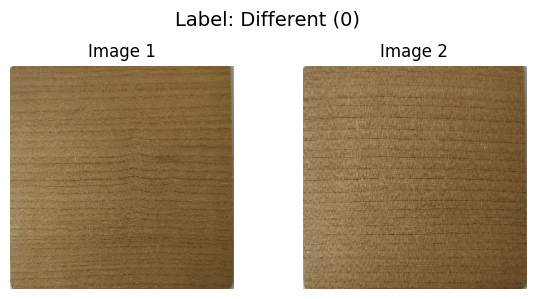

In [6]:
# Take a single pair from the dataset
random_pair = random.choice(val_pairs)
show_image_pair_from_paths(*random_pair)


The following function help visualise the effect of the augmentation pipeline on the images.

2025-09-01 22:50:43.696247: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


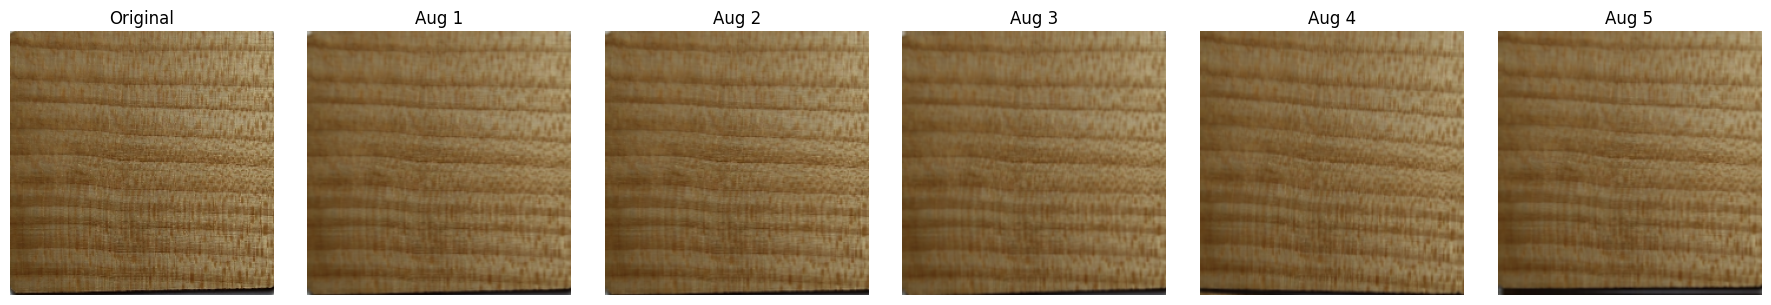

In [7]:
# Optional function to visualize data augmentation
def visualize_augmentations(image_path, num_copies=5, target_size=(224,224)):
    # 1) Load & preprocess a single image (dtype maybe float16)
    img = load_and_preprocess_image(image_path, target_size)

    # 2) Plot original + augmented variants
    fig, axes = plt.subplots(1, num_copies+1, figsize=(3*(num_copies+1), 3))
    
    # cast to float32 for plotting
    orig = tf.cast(img, tf.float32).numpy()
    axes[0].imshow(orig)
    axes[0].set_title("Original")
    axes[0].axis("off")

    for i in range(num_copies):
        # apply augment (still float16 or float32)
        aug = data_augmentation(img, training=True)
        # cast for plotting
        aug32 = tf.cast(aug, tf.float32).numpy()
        axes[i+1].imshow(aug32)
        axes[i+1].set_title(f"Aug {i+1}")
        axes[i+1].axis("off")

    plt.tight_layout()
    plt.show()

# Example:
visualize_augmentations(test_paths[65], num_copies=5)


Further down a few function are created to be used during model evaluation


In [8]:
def predict_image_pair(
    model,
    img1_path,
    img2_path,
    target_size=(224, 224),
    threshold=1.0,
    visual=True,
    verbose=True,
):
    # 1) Load images with the SAME preprocessing you used at train time
    img1 = load_image(img1_path, target_size)   # should return HxWxC float32, normalized as in training
    img2 = load_image(img2_path, target_size)

    # 2) Ensure batch dimension
    if tf.rank(img1) == 3:
        img1 = tf.expand_dims(img1, axis=0)
    if tf.rank(img2) == 3:
        img2 = tf.expand_dims(img2, axis=0)

    # (optional) ensure dtype+
    img1 = tf.cast(img1, tf.float32)
    img2 = tf.cast(img2, tf.float32)

    # 3) Predict
    pred = model.predict([img1, img2], verbose=0)
    score = float(tf.squeeze(pred).numpy())  # scalar

    # 4) Interpret according to output kind
    dist = score
    is_same = dist <= threshold
    if verbose:
         print(f"Predicted distance: {dist:.4f} (threshold={threshold})")
         print(f"Prediction: {'Same' if is_same else 'Different'} (is_same={is_same})")
    if visual:
        show_image_pair_from_paths(img1_path, img2_path, is_same)
    return is_same, dist

In [ ]:
# # create function to calculate distance between two vectors

# def euclidean_distance(vects):
#     x, y = vects
#     return tf.sqrt(tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True) + tf.keras.backend.epsilon())



# # Create Loss function

# def loss(margin=1.0):
#     def contrastive_loss(y_true, y_pred):
#         return ops.mean(
#             y_true * ops.square(y_pred)
#           + (1 - y_true) * ops.square(ops.maximum(margin - y_pred, 0))
#         )
#     return contrastive_loss


In the next section an existing model can be imported:

In [ ]:
# ###### facultative section to load an existing model #################


# siamese = load_model(
#     "siamese_mode_MV2_NA.keras",
#     custom_objects={
#       "euclidean_distance": euclidean_distance,
#       "contrastive_loss": loss
#     }
# )

# # Extract the embedding sub‐model by name
# embedding_network = siamese.get_layer("resnet_embedding")

# for layer in embedding_network.layers:
#     if isinstance(layer, tf.keras.Model) or "mobilenetv2" in layer.name:
#         backbone = layer
#         break
# else:
#     raise RuntimeError("Could not find the backbone inside the embedding network")

# # Check if the model looks right
# embedding_network.summary()


/home/gaspard/projects/my-ml-app/mycuda/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 12 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/gaspard/projects/my-ml-app/mycuda/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "resnet_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ unit_normalization              │ (None, 128)            │             0 │
│ (UnitNormalization)             │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,623,936 (10.01 MB)

 Trainable params: 363,392 (1.39 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

# Part 3: Model Building

In this section, three different models are compared. The first model is a simple CNN hand-made model. 
Then two different pretrained model are used, MobilNetV2 and ResNet50. 
The goal of using three different models is to be able to compare the influence of the model complexity on the model accuracy. 
A hand-made CNN is fast to train and to use but could be limited from its architecture to learn complex features. 
The MobilenetV2 is a pre-trained model first presented by [Sandler et al. ] in 2018, with 3.5M parameters it is specifally designed for mobile/lightweight application, and would therefore be ideal for an usage on a mobile device.
The Resnet50 is also a pretrained model with ~25.6M parameters first presented in 2015 by [Kaiming He et al.], which typically has a higher accuracy but is slower than MobilnetV2. 
As the MobilnetV2 and Resnet50 are large model, they requires a training in different steps. First the backbone of the model are frozen, and just the head is fitted to the data for a short amount of epochs. Then a portion of the model is unfrozen and the training is resumed. This approach avoid erasing pre-learned features from the model. 

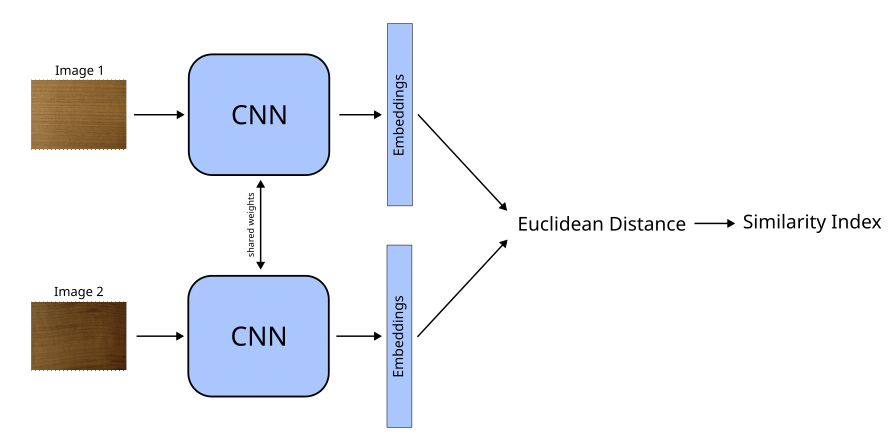



In [10]:
# create function to calculate distance between two vectors

def euclidean_distance(vects):
    x, y = vects
    return tf.sqrt(tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True) + tf.keras.backend.epsilon())


# Create Loss function

def loss(margin=1.0):
    def contrastive_loss(y_true, y_pred):
        return ops.mean(
            y_true * ops.square(y_pred)
          + (1 - y_true) * ops.square(ops.maximum(margin - y_pred, 0))
        )
    return contrastive_loss


### Hand-Made CNN Model

In [ ]:
#Model Definition HAND-MADE CNN

input = keras.layers.Input((224, 224, 3))
x = keras.layers.BatchNormalization()(input)

x = layers.Conv2D(16, (3,3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)

# final embedding vector
x = layers.Dense(128)(x)
x = layers.UnitNormalization(axis=1)(x)  # normalize embeddings

embedding_network = keras.Model(input, x, name="resnet_embedding")

# 3) Siamese towers reuse the same embedding_network
input_1 = layers.Input((224, 224, 3), name="input_a")
input_2 = layers.Input((224, 224, 3), name="input_b")
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))(
    [tower_1, tower_2]
)

# normal_layer = keras.layers.BatchNormalization()(merge_layer)
# output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=merge_layer)



### Importation of Pre-trained CNN Model

In [9]:
# The MobilenetV2 and Resnet50 can be easily switched by importing a different backbone:

backbone = ResNet50(          # model MobilNetV2 or ResNet50 can be chosen --> simply replace "MobileNetV2" with "ResNet50"
    include_top=False,        # drop the ImageNet FC
    weights="imagenet",       # load pretrained weights
    input_shape=(224, 224, 3),
    pooling="avg"             # global average‐pool → a flat vector
)
backbone.trainable = False    # For the first training, all layers are frozen. They are unfrozen later for the second fitting.

# Build the embedding neck on top of it
inp = layers.Input((224, 224, 3))
x   = backbone(inp)
x   = layers.BatchNormalization()(x)
x   = layers.Dense(256, activation="relu")(x)   
x   = layers.Dropout(0.2)(x)
x   = layers.Dense(128)(x)                # final embedding
x   = layers.UnitNormalization(axis=1)(x)  # normalize embeddings
embedding_network = keras.Model(inp, x, name="resnet_embedding")

# 3) Siamese towers reuse the same embedding_network
input_1 = layers.Input((224, 224, 3), name="input_a")
input_2 = layers.Input((224, 224, 3), name="input_b")
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))(
    [tower_1, tower_2]
)

#normal_layer = keras.layers.BatchNormalization()(merge_layer)
# output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=merge_layer)


### Model Compilation

To evaluate the performance of a siamese network, the accuracy is not the best metrics as it suffer from arbitrary thresholds and from class imbalance (more negative pairs as positive pairs). That is why for this task a contrastive evaluator function is built. This approach deliver better result as it evaluates the separability of embeddings across all thresholds. 

In [ ]:
margin = 1  # Margin for contrastive loss.

class ContrastiveEvaluator(tf.keras.callbacks.Callback):
    def __init__(self, val_dataset, margin=1.0):
        """
        val_dataset: your tf.data.Dataset yielding ((img1, img2), label) pairs
        margin:      not used for AUC but could be if you want a threshold
        """
        super().__init__()
        self.val_dataset = val_dataset

    def on_epoch_end(self, epoch, logs=None):
        # Gather model outputs (distances) and true labels
        dists = []
        labels = []
        for (x1, x2), y in self.val_dataset:
            # model.predict returns the Euclidean distance for each pair
            preds = self.model.predict([x1, x2], verbose=0)
            dists.extend(preds.flatten())
            labels.extend(y.numpy().flatten())

        dists  = np.array(dists)
        labels = np.array(labels)

        # We use –distance as the “similarity” score for ROC
        auc = roc_auc_score(labels, -dists)
        
        # Log it so it appears in history.history['val_auc_cb']
        logs = logs or {}
        logs['val_auc_cb'] = auc
        
        print(f" — val_auc_cb: {auc:.4f}")

siamese.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=loss(margin=margin),
)
siamese.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_a             │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_b             │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet_embedding    │ (None, 128)       │ 24,153,344 │ input_a[0][0],    │
│ (Functional)        │                   │            │ input_b[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ resnet_embedding… │
│                     │                   │            │ resnet_embedding… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,153,344 (92.14 MB)

 Trainable params: 561,536 (2.14 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

## Part 4: Model Training

The training of the MobileNetV2 and ResNet50 model is done in two parts. First the model is trained with frozen layers, then a part of the model is unfrozen. The second learning is done with a smaller learning rate to avoid overwriting pretrained features of the model. 


In [ ]:

# if MobileNetV2 and Resnet50 are chosen this first training is done with the frozen layers

batch_size = 16
steps_per_epoch  = len(train_pairs) // batch_size
validation_steps = len(val_pairs)   // batch_size

history = siamese.fit(
    train_ds,
    epochs=3,
    steps_per_epoch=steps_per_epoch,       # ← stop after this many
    validation_data=val_ds,
    callbacks=   [ContrastiveEvaluator(val_ds)]
)

Epoch 1/3


2025-08-30 12:11:59.392326: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_12}}
/home/gaspard/projects/my-ml-app/mycuda/lib/python3.12/site-packages/tensorflow/python/util/numpy_compat.py:47: RuntimeWarning: overflow encountered in cast
  return np.array(values, copy=copy, order=order).astype(dtype)
I0000 00:00:1756548724.774043   89370 cuda_dnn.cc:529] Loaded cuDNN versi

1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 0.1260

2025-08-30 12:16:57.475006: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-08-30 12:17:00.448020: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

 — val_auc_cb: 0.8531
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 317s 291ms/step - loss: 0.1259 - val_loss: 0.1800 - val_auc_cb: 0.8531
Epoch 2/3


2025-08-30 12:17:16.185188: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 0.0863

2025-08-30 12:22:03.468728: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-08-30 12:22:08.919256: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

 — val_auc_cb: 0.8687
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 300s 283ms/step - loss: 0.0863 - val_loss: 0.1670 - val_auc_cb: 0.8687
Epoch 3/3


2025-08-30 12:22:16.641945: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 0.0732

2025-08-30 12:27:05.046304: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-08-30 12:27:07.990637: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

 — val_auc_cb: 0.8577
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 301s 283ms/step - loss: 0.0731 - val_loss: 0.1592 - val_auc_cb: 0.8577


In [ ]:
# Optional part to unfreeze 25% of the top layers. To use on MobileNetV2 and ResNet50

total = len(backbone.layers)
cut   = int(total * 0.75)   # freeze bottom 75%, unfreeze top 25%
for layer in backbone.layers[:cut]:
    layer.trainable = False
for layer in backbone.layers[cut:]:
    layer.trainable = True



# Recompile with a smaller learning rate for fine-tuning
siamese.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=loss(margin=margin),
)

siamese.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_a             │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_b             │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet_embedding    │ (None, 128)       │ 24,153,344 │ input_a[0][0],    │
│ (Functional)        │                   │            │ input_b[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ resnet_embedding… │
│                     │                   │            │ resnet_embedding… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,153,344 (92.14 MB)

 Trainable params: 8,442,752 (32.21 MB)

 Non-trainable params: 15,710,592 (59.93 MB)

In [17]:
#  Continue training
history = siamese.fit(
    train_ds,
    epochs=10,
    steps_per_epoch=steps_per_epoch,      
    validation_data=val_ds,
    validation_steps=validation_steps,     
    callbacks=   [
        ContrastiveEvaluator(val_ds), 
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10), #reduce learning rate further if necessary
    ]
)

Epoch 1/10


/home/gaspard/projects/my-ml-app/mycuda/lib/python3.12/site-packages/tensorflow/python/util/numpy_compat.py:47: RuntimeWarning: overflow encountered in cast
  return np.array(values, copy=copy, order=order).astype(dtype)


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 0.1169

2025-08-30 12:33:53.691321: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-08-30 12:33:59.158588: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

 — val_auc_cb: 0.7731
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 321s 293ms/step - loss: 0.1169 - val_loss: 0.3215 - val_auc_cb: 0.7731 - learning_rate: 1.0000e-05
Epoch 2/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 0.0829

2025-08-30 12:39:03.507720: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-08-30 12:39:08.953150: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

 — val_auc_cb: 0.8711
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 308s 290ms/step - loss: 0.0829 - val_loss: 0.2093 - val_auc_cb: 0.8711 - learning_rate: 1.0000e-05
Epoch 3/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 0.0748

2025-08-30 12:44:11.609319: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-08-30 12:44:17.133412: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

 — val_auc_cb: 0.8605
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 309s 291ms/step - loss: 0.0748 - val_loss: 0.2055 - val_auc_cb: 0.8605 - learning_rate: 1.0000e-05
Epoch 4/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 0.0670

2025-08-30 12:49:20.294519: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-08-30 12:49:25.861570: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

 — val_auc_cb: 0.8827
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 306s 288ms/step - loss: 0.0670 - val_loss: 0.3058 - val_auc_cb: 0.8827 - learning_rate: 1.0000e-05
Epoch 5/10


2025-08-30 12:49:34.651327: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 0.0653

2025-08-30 12:54:26.050051: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-08-30 12:54:31.550540: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

 — val_auc_cb: 0.8913
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 308s 290ms/step - loss: 0.0653 - val_loss: 0.1776 - val_auc_cb: 0.8913 - learning_rate: 1.0000e-05
Epoch 6/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 0.0621

2025-08-30 12:59:34.360477: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-08-30 12:59:39.826180: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

 — val_auc_cb: 0.8565
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 308s 290ms/step - loss: 0.0621 - val_loss: 0.2758 - val_auc_cb: 0.8565 - learning_rate: 1.0000e-05
Epoch 7/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 0.0595

2025-08-30 13:04:42.781865: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-08-30 13:04:48.357251: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

 — val_auc_cb: 0.8818
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 306s 288ms/step - loss: 0.0595 - val_loss: 0.2174 - val_auc_cb: 0.8818 - learning_rate: 1.0000e-05
Epoch 8/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 0.0578

2025-08-30 13:09:49.931377: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-08-30 13:09:53.014815: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

 — val_auc_cb: 0.8864
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 307s 289ms/step - loss: 0.0578 - val_loss: 0.3788 - val_auc_cb: 0.8864 - learning_rate: 1.0000e-05
Epoch 9/10
1059/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 0.0549

2025-08-30 13:14:54.889680: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-08-30 13:15:00.366045: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

 — val_auc_cb: 0.8853
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 307s 289ms/step - loss: 0.0549 - val_loss: 0.3067 - val_auc_cb: 0.8853 - learning_rate: 1.0000e-05
Epoch 10/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 0.0527

2025-08-30 13:20:02.306722: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-08-30 13:20:07.814271: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

 — val_auc_cb: 0.8772
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 305s 287ms/step - loss: 0.0527 - val_loss: 0.2457 - val_auc_cb: 0.8772 - learning_rate: 1.0000e-05


## Part 5: Model testing

After the training is complete, the evolution of the contrastive loss is plotted with the number of epochs. Then the performance of the model on the test set is evaluated. The model can also be saved to allow for further evaluation without having to train from scratch the model.

In [12]:
# Plotting the performance of the model

def plt_metric(history, metric, title, has_valid=True):

    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")


NameError: name 'history' is not defined

In [ ]:
# Run prediction on the test set to collect distances
dists = siamese.predict(test_ds, verbose=1)    # shape: (num_pairs, 1)
dists = dists.flatten()                        # shape: (num_pairs,)

# Collect the true labels from the dataset
labels = []
for (x1, x2), y in test_ds:
    labels.append(y.numpy().flatten())
labels = np.concatenate(labels, axis=0)        # shape: (num_pairs,)

# Compute ROC-AUC using –distance as similarity score
test_auc = roc_auc_score(labels, -dists)
print(f"Test ROC-AUC on distances: {test_auc:.4f}")

/home/gaspard/projects/my-ml-app/mycuda/lib/python3.12/site-packages/tensorflow/python/util/numpy_compat.py:47: RuntimeWarning: overflow encountered in cast
  return np.array(values, copy=copy, order=order).astype(dtype)


68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step
Test ROC-AUC on distances: 0.9513


### OPTIONAL PART:
### SAVE a trained model to resume usage later

In [ ]:
####### Optional Block used to save the model ########
# Be careful to not overwrite model!

# at the end of training
siamese.save("siamese_model_R50_WA.h5")

# At the end of training
siamese.save("siamese_model_R50_WA.keras")


### IMPORT a trained model and result evaluation

In [11]:
############## OPTIONAL BLOCK : USE TO LOAD A SAVED MODEL ######################

siamese = load_model(
    "siamese_mode_resnet50_noAUG.keras",
    custom_objects={
      "euclidean_distance": euclidean_distance,
      "contrastive_loss": loss
    }
)

# Extract the embedding sub‐model by name
embedding_network = siamese.get_layer("resnet_embedding")

for layer in embedding_network.layers:
    if isinstance(layer, tf.keras.Model) or "mobilenetv2" in layer.name:
        backbone = layer
        break
else:
    raise RuntimeError("Could not find the backbone inside the embedding network")

# Check if the model looks right
embedding_network.summary()


/home/gaspard/projects/my-ml-app/mycuda/lib/python3.12/site-packages/keras/src/trainers/trainer.py:212: UserWarning: Model doesn't support `jit_compile=True`. Proceeding with `jit_compile=False`.
  warnings.warn(
/home/gaspard/projects/my-ml-app/mycuda/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 52 variables whereas the saved optimizer has 98 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/gaspard/projects/my-ml-app/mycuda/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 48 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "resnet_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,153,344 (92.14 MB)

 Trainable params: 15,537,536 (59.27 MB)

 Non-trainable params: 8,615,808 (32.87 MB)

# Part 6: Results and Discussion

In this part, the learning of the model is verified, first the euclidean distance of images from the same and differente classes is compared. 
The distance between class 1 to 10 is calculated using the formula below:


In [46]:
#function to calculate the average class distance as presented in the table above.

distvec = [] #empty vector to store the euclidean embeddings distance
for i in range(1,11):
    for j in range(1,11):
        img1_path = "/home/gaspard/projects/my-ml-app/data/TRAIN/C9/"+str(i)+".jpg"
        img2_path = "/home/gaspard/projects/my-ml-app/data/TRAIN/C10/"+str(j)+".jpg"  # same class → should be predicted as 'same'
        _, dist = predict_image_pair(siamese, img1_path, img2_path , threshold=0.5, visual=False, verbose = False)
        distvec.append(dist)

print("mean different-class distance:", np.mean(distvec))
print("std:", np.std(distvec))
    


2025-08-27 23:56:24.821402: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-08-27 23:56:30.185241: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

mean different-class distance: 0.8641015625
std: 0.09776817024116125


A more precise approach consist in calculating the ROC curve and calculating the Youden optimal threshold:

2025-08-28 20:23:44.050892: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-08-28 20:23:49.527343: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

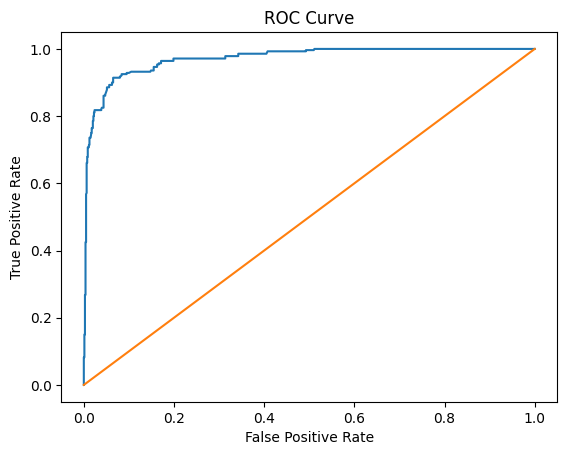

Optimal threshold (Youden’s J): -0.6899
 → TPR: 0.914, FPR: 0.065
Threshold for TPR≥0.95: -0.8398 (FPR: 0.163)


In [ ]:
# Computes and plots the ROC curve for a Siamese model on a given tf.data.Dataset.
def plot_roc(model, dataset):
    dists, labels = [], []
    for (x1, x2), y in dataset:
        preds = model.predict([x1, x2], verbose=0).flatten()
        dists.extend(preds)
        labels.extend(y.numpy().flatten())
    dists = np.array(dists)
    labels = np.array(labels)

    # Compute ROC
    fpr, tpr, thresholds = roc_curve(labels, -dists)

    # Plot
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1])  # chance line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    return fpr, tpr, thresholds

# Usage example:
fpr, tpr, thresholds = plot_roc(siamese, test_ds)

# Compute Youden’s J and find the best index
youden_j = tpr - fpr
best_idx = np.argmax(youden_j)
best_thresh = thresholds[best_idx]

print(f"Optimal threshold (Youden’s J): {best_thresh:.4f}")
print(f" → TPR: {tpr[best_idx]:.3f}, FPR: {fpr[best_idx]:.3f}")

# (Optional) for a specific threshold that gives for example ≥95% TPR:
target_tpr = 0.95
idx95 = np.where(tpr >= target_tpr)[0][0]
thresh_95tpr = thresholds[idx95]
print(f"Threshold for TPR≥0.95: {thresh_95tpr:.4f} (FPR: {fpr[idx95]:.3f})")

In [ ]:
#OLD to erase
# siamese = load_model(
#     "siamese_mode_resnet50_noAUG.keras",
#     custom_objects={
#       "euclidean_distance": euclidean_distance,
#       "contrastive_loss": loss
#     }
# )

# # Extract the embedding sub‐model by name
# embedding_network = siamese.get_layer("resnet_embedding")

# for layer in embedding_network.layers:
#     if isinstance(layer, tf.keras.Model) or "mobilenetv2" in layer.name:
#         backbone = layer
#         break
# else:
#     raise RuntimeError("Could not find the backbone inside the embedding network")

# # Check if the model looks right
# embedding_network.summary()


/home/gaspard/projects/my-ml-app/mycuda/lib/python3.12/site-packages/keras/src/trainers/trainer.py:212: UserWarning: Model doesn't support `jit_compile=True`. Proceeding with `jit_compile=False`.
  warnings.warn(
/home/gaspard/projects/my-ml-app/mycuda/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 52 variables whereas the saved optimizer has 98 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/gaspard/projects/my-ml-app/mycuda/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 48 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Creation of the embeddings database
In this part the embeddings database is built and the nearest neighbors strategy is implemented. 
 part is implemented to build the retrieval part of the algorithm. 

In [14]:
# Creation of the Embeddings Database containing all the embeddings of the train, val and 80% of the test set. 
# And creation of a few function to get the embedding of single image and compare it the database

# Build a tf.data pipeline
ds = (
    tf.data.Dataset
      .from_tensor_slices(paths)
      .map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(16)
      .prefetch(tf.data.AUTOTUNE)
)
ds = ds.with_options(options)

#Run one big pass to get all embeddings (shape = [num_paths, emb_dim])
embeddings = embedding_network.predict(ds, verbose=1)


# Fit a NearestNeighbors index on those embeddings
nn = NearestNeighbors(
    n_neighbors=1,
    algorithm='brute',
    metric='euclidean'
).fit(embeddings)


# Helper to get the embedding for a single image
def get_embedding(path):
    img = load_and_preprocess_image(path, target_size=(224, 224))
    img = np.expand_dims(img, axis=0)   # make batch of 1
    emb = embedding_network.predict(img, verbose=0)
    return emb  # shape (1, emb_dim)


# Query for the single most similar card
def find_most_similar(query_path):
    q_emb = get_embedding(query_path)  # (1, D)
    dist, idx = nn.kneighbors(q_emb, n_neighbors=1)
    best_i = idx[0][0]
    return paths[best_i], dist[0][0]




74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step


In this part a specific image can be selected and the corresping class can be retrieved.

2025-09-01 23:03:09.594594: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Query: /home/gaspard/projects/my-ml-app/data/TRAIN/C60/9.jpg
Most similar in index: /home/gaspard/projects/my-ml-app/data/TRAIN/C67/6.jpg
Distance: 0.0562
Predicted distance: 0.0560 (threshold=0.2)
Prediction: Same (is_same=True)


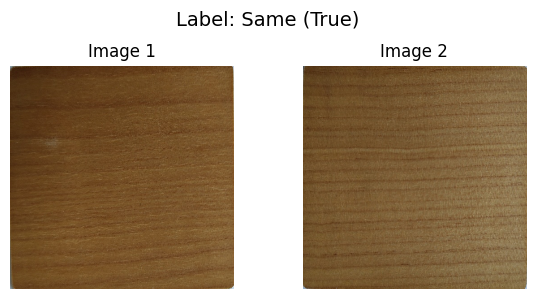

In [15]:
# a specific image can be selected and the most similar image can be retrieved:

# img_path = '/home/gaspard/projects/my-ml-app/data/TRAIN/C15/1.jpg' # directly input the path or...
img_path = N_test_paths[9] #... or use the pre-made set

best_path, best_dist= find_most_similar(img_path)
print(f"Query: {img_path}")
print(f"Most similar in index: {best_path}")
print(f"Distance: {best_dist:.4f}")

# by using this function (with the option visual=True), the input card and the most similar card can be visualised.
is_same, dist = predict_image_pair(siamese, img_path, best_path , threshold=0.2, visual=True)


This function help verify if all the images of the N-test-set are correctly classified:

In [ ]:
leng = len(N_test_paths)
bad_match = 0
for i in range(leng):
    img_path = N_test_paths[i]
    best_path, best_dist= find_most_similar(img_path)
    if os.path.dirname(img_path) != os.path.dirname(best_path):
        print("Class", i, "wrongly classified.")
        bad_match +=1

print("In total", bad_match/leng*100, " % are badly classified")



2025-09-01 23:04:59.089165: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Class 0 wrongly classified.
Class 1 wrongly classified.
Class 4 wrongly classified.
Class 5 wrongly classified.
Class 9 wrongly classified.
Class 12 wrongly classified.
Class 13 wrongly classified.
Class 14 wrongly classified.
Class 16 wrongly classified.
Class 18 wrongly classified.
In total 50.0  % are badly classified


Further helper function to visualize and test if two images are from the same class

2025-08-23 23:13:54.596865: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


Predicted distance: 0.2311 (threshold=0.9)
Prediction: Same (is_same=True)


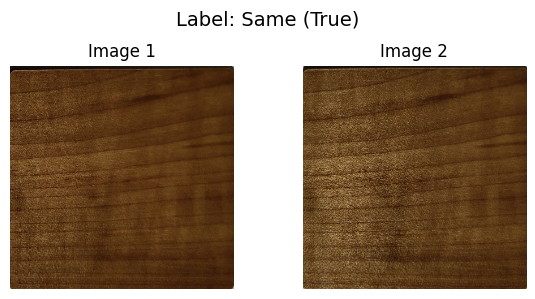

In [35]:
#script to test a specific card:

pathtotest = "/home/gaspard/projects/my-ml-app/data/TRAIN/C10/4.jpg"
pathtotest2 = "/home/gaspard/projects/my-ml-app/data/TRAIN/C10/3.jpg"
is_same, dist = predict_image_pair(siamese, pathtotest2, pathtotest , threshold=0.9, visual=True)

# Conclusion and Outlook

It was shown that a Siamese convolutional deep network can distinguish wood features and identify with an accuracy of > 95% positive from negative pairs. Such a model was then used as embedding head to be able to retrieve the class from a new card. Three different CNN architectures were compared, a hand-made CNN, and two pretrained model, ResNet50 and MobilenetV2. Their performances were compared using different parameters and a data augmentation pipeline. the Handmade CNN performed poorly and failed to distinguish the fine wood pattern difference. The ResNet50 had lower performance than the MobileNetV2, which was able to correctly classify all unknown cards. These positive results need to be verified on a bigger dataset with more variability, also the following learning strategy could be implemented to increase the performance of the model:

- Increase data set size to increase the number of positive pairs
- Change the network architecture to implement Triplet Loss and data mining (according to pairs which are difficult for the model to identify)
- Improve the data augmentation method to avoid artifact

These preliminary results show the viability of using wood pattern as a unique identifier for user identification. The present architectures should be easily deployable on mobile usage, with a light model such as MobileNetV2 and with a fast retrieval strategy using KNN. Further work will however be necessary to be able to make the model more robust in real life scenarios (variable light conditions, different angles, fast local computing on smartphones, etc). 


The explanation in this script are kept short. Please refer to the PDF to further explanation concerning the approach and the discussion about the results. 